In [2]:
# Tensorflow
import tensorflow as tf 
print(f'tf version is {tf.__version__}')

tf version is 2.4.1


In [3]:
import matplotlib.pyplot as plt

# Eager Execution
tf.executing_eagerly()


True

In [4]:
train_dataset_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv"
train_dataset_fp = tf.keras.utils.get_file(fname='iris_training.csv',origin=train_dataset_url)
print(train_dataset_fp)

/home/gordon/.keras/datasets/iris_training.csv


In [5]:
test_dataset_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv"
test_dataset_fp = tf.keras.utils.get_file(fname='iris_test.csv',origin=test_dataset_url)
print(test_dataset_fp)

/home/gordon/.keras/datasets/iris_test.csv


In [6]:
feature_names = ['sepal_length','sepal_width',
        'petal_length','petal_width']

label_name = 'species'
column_names = feature_names + [label_name]

In [7]:
import pandas as pd
batch_size = 32

train_df = pd.read_csv(train_dataset_fp,skiprows=1,names=column_names)
features_df = train_df[feature_names]
label_df = train_df[label_name]

train_dataset = tf.data.Dataset.from_tensor_slices((features_df,label_df)).batch(batch_size)

test_df = pd.read_csv(train_dataset_fp,skiprows=1,names=column_names)
features_df = test_df[feature_names]
label_df = test_df[label_name]

test_dataset = tf.data.Dataset.from_tensor_slices((features_df,label_df)).batch(batch_size)

next_batch_dataset = next(iter(train_dataset))

2021-09-02 17:27:28.528924: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-02 17:27:28.534990: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-02 17:27:28.536818: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


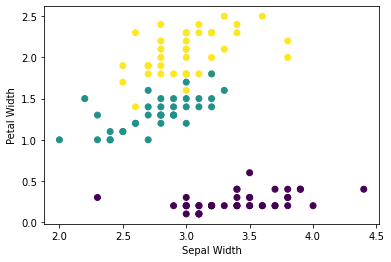

In [8]:

plt.scatter(features_df['sepal_width'],
    features_df['petal_width'],
    c=label_df
)

plt.xlabel('Sepal Width')
plt.ylabel('Petal Width')
plt.show()

In [9]:
# Initialize 個model 

model = tf.keras.Sequential([
    tf.keras.layers.Dense(10,activation=tf.nn.relu,input_shape=(4,)), # 係 4,batch_size
    tf.keras.layers.Dense(10,activation=tf.nn.relu) ,
    tf.keras.layers.Dense(3)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                50        
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 33        
Total params: 193
Trainable params: 193
Non-trainable params: 0
_________________________________________________________________


In [10]:
features, labels = next_batch_dataset
# output = model(input)
predictions = model(features)
print(predictions)
tf.nn.softmax(predictions[:5])
# 佢現家答出嘅嘢係垃圾，因為未train

print("Prediction: {}".format(tf.argmax(predictions, axis=1)))

tf.Tensor(
[[ 1.3282115  -1.5002756  -1.3630245 ]
 [ 0.8983188  -0.71224546 -0.65071905]
 [ 1.1225373  -1.2556005  -1.11321   ]
 [ 0.21322998 -0.28762558  0.04595003]
 [ 0.25271887 -0.35767525  0.06643286]
 [ 0.18582477 -0.29484162  0.05447908]
 [ 0.28758305 -0.29361135  0.08210061]
 [ 1.4116251  -1.1975802  -1.1124028 ]
 [ 1.2243035  -0.94427174 -0.8639215 ]
 [ 0.23146367 -0.35601324  0.07077537]
 [ 1.0429156  -0.929258   -0.818943  ]
 [ 1.285579   -1.1461093  -1.0495167 ]
 [ 0.2328315  -0.3943073   0.06439774]
 [ 0.2629063  -0.38603318  0.05770409]
 [ 1.616667   -1.8110325  -1.6008792 ]
 [ 1.2330583  -1.1109064  -0.97015893]
 [ 1.468833   -1.5821564  -1.4263576 ]
 [ 1.5037583  -1.8076403  -1.6602902 ]
 [ 1.4136884  -1.3626807  -1.2264974 ]
 [ 0.24724984 -0.40782857  0.07164183]
 [ 1.4585532  -1.5202324  -1.3605022 ]
 [ 1.3311558  -1.5117843  -1.373079  ]
 [ 0.23842466 -0.3871112   0.06903099]
 [ 1.2159024  -1.579287   -1.4113758 ]
 [ 1.3804803  -1.5257735  -1.3955407 ]
 [ 0.21208042 

In [11]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True)

In [12]:
def loss(model,x,y, training=True):
    y_ = model(x,training = training)
    # y_true係理想
    # y_pred 係現實
    return loss_object(y_true=y, y_pred=y_)

l = loss(model,features,labels,training= False)
print(l)

tf.Tensor(2.0726721, shape=(), dtype=float32)


In [13]:
def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, training=True)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

# learning_rate 要係呢度set，而你一開唔知係幾多嘅
optimizer = tf.keras.optimizers.SGD(learning_rate= 0.01)

In [14]:

# Single Optimization Step
loss_value, grads = grad(model,features,labels)
print(loss_value)
print(grads) # 對應每一粒 trainable variable(weight/bias)應該點改
optimizer.apply_gradients(zip(grads, model.trainable_variables))


print(model.trainable_variables)

tf.Tensor(2.0726721, shape=(), dtype=float32)
[<tf.Tensor: shape=(4, 10), dtype=float32, numpy=
array([[ 2.3795376 , -0.17654735,  1.7899436 ,  0.        , -1.0803251 ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 1.0469658 , -0.10164659,  0.7546098 ,  0.        , -0.47966325,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 2.0388777 , -0.10931227,  1.5586848 ,  0.        , -0.9034885 ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.7175824 , -0.03470423,  0.54557407,  0.        , -0.34259808,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ]],
      dtype=float32)>, <tf.Tensor: shape=(10,), dtype=float32, numpy=
array([ 0.36624843, -0.02962235,  0.277195  ,  0.        , -0.16676314,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
      dtype=float32)>, <tf.Tensor: shape=(10, 10), dtype=float32, numpy=
array([[-7.59633601e-01,  8

In [21]:
# 呢個parameter 又係要試
num_epochs = 201

# 同理想差幾遠平均嘅list
train_loss_results = []
# percentage有幾多個中咗理想嘅label
train_accuracy_results = []

for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

    for x,y in train_dataset:             
        loss_value, grads = grad(model,x,y)
        optimizer.apply_gradients(zip(grads,
            model.trainable_variables))
        epoch_loss_avg.update_state(loss_value)
        # y 係理想，後面係model 估嘅data
        epoch_accuracy.update_state(y, model(x, training=True))
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())
    if epoch % 10 == 0:
        print(f'Epoch {epoch} loss:{epoch_loss_avg.result()} accuracy:{epoch_accuracy.result()}')

Epoch 0 loss:0.22552159428596497 accuracy:0.9833333492279053
Epoch 10 loss:0.21292459964752197 accuracy:0.9833333492279053
Epoch 20 loss:0.20151875913143158 accuracy:0.9833333492279053
Epoch 30 loss:0.1910407990217209 accuracy:0.9833333492279053
Epoch 40 loss:0.1817154735326767 accuracy:0.9833333492279053
Epoch 50 loss:0.17337864637374878 accuracy:0.9833333492279053
Epoch 60 loss:0.16588160395622253 accuracy:0.9833333492279053
Epoch 70 loss:0.1590169370174408 accuracy:0.9833333492279053
Epoch 80 loss:0.15306055545806885 accuracy:0.9833333492279053
Epoch 90 loss:0.14763253927230835 accuracy:0.9833333492279053
Epoch 100 loss:0.14262758195400238 accuracy:0.9833333492279053
Epoch 110 loss:0.13818028569221497 accuracy:0.9833333492279053
Epoch 120 loss:0.1340983659029007 accuracy:0.9833333492279053
Epoch 130 loss:0.13040319085121155 accuracy:0.9833333492279053
Epoch 140 loss:0.12699191272258759 accuracy:0.9833333492279053
Epoch 150 loss:0.12397018820047379 accuracy:0.9833333492279053
Epoch 1

In [22]:
features, labels = next_batch_dataset
# output = model(input)
predictions = model(features)
tf.nn.softmax(predictions[:5])

print("Prediction: {}".format(tf.argmax(predictions, axis=1)))

Prediction: [2 1 2 0 0 0 0 2 1 0 1 1 0 0 2 1 2 2 2 0 2 2 0 2 2 0 1 2 1 1 1 1]


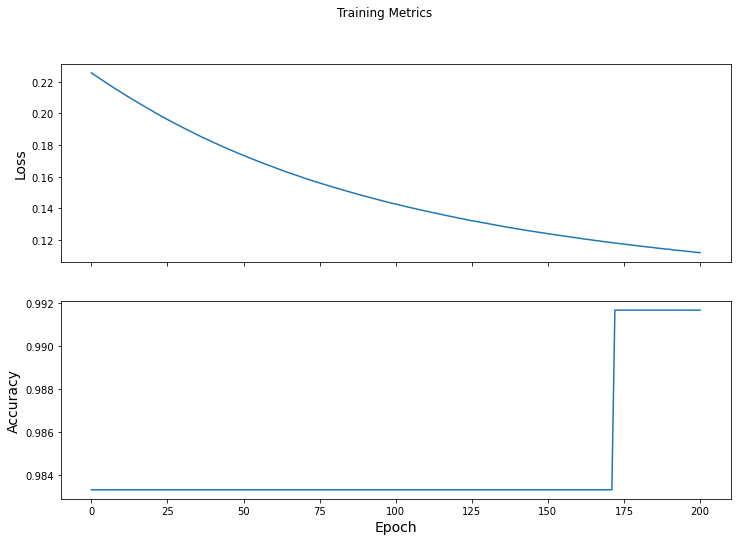

In [23]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

In [24]:
model.trainable_variables

[<tf.Variable 'dense/kernel:0' shape=(4, 10) dtype=float32, numpy=
 array([[ 0.10124798,  0.9808722 , -0.04035832, -0.39027047,  0.38692844,
         -0.37787855, -0.4889679 , -0.15290737, -0.43302387, -0.2982588 ],
        [-0.58947843,  0.710517  ,  0.55497384, -0.30398872, -0.5221215 ,
          0.49052393, -0.46675   ,  0.24593872,  0.50839806, -0.53445745],
        [ 0.79573125, -0.94225866, -0.12949236, -0.4252813 ,  0.44273844,
         -0.3715641 ,  0.5035287 , -0.36325714, -0.47937214,  0.09625286],
        [ 0.99579984, -0.38377535, -0.37208632,  0.4046868 ,  0.9254807 ,
         -0.5951872 ,  0.6019685 , -0.13724333, -0.13190019, -0.3782725 ]],
       dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(10,) dtype=float32, numpy=
 array([-0.10494248,  0.30392373,  0.07901951,  0.        ,  0.00309488,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       dtype=float32)>,
 <tf.Variable 'dense_1/kernel:0' shape=(10, 10) dtype=float32, numpy=
 array([

In [27]:
test_accuracy = tf.keras.metrics.Accuracy()

for x,y in test_dataset:
    logits = model(x,training=False)
    prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
    test_accuracy(prediction, y)

print(f'Test Accuracy: {test_accuracy.result()}')

Test Accuracy: 0.9583333134651184


In [26]:
model.save('./',overwrite=True)

INFO:tensorflow:Assets written to: ./assets
